In [1]:
! pip install -q "gdown==5.2.0"

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
!gdown --id 1aOm_WJ53R7lk16Azz_NSNumvFV3aNO39

In [ ]:
!unzip lung_cancer_dataset.zip

In [5]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)


    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [6]:
data_dir = '/content/lung_cancer_dataset'
df = loading_the_data(data_dir)
df

,filepaths,labels
0,/content/lung_cancer_dataset/Bengin cases/Beng...,Bengin cases
1,/content/lung_cancer_dataset/Bengin cases/Beng...,Bengin cases
2,/content/lung_cancer_dataset/Bengin cases/Beng...,Bengin cases
3,/content/lung_cancer_dataset/Bengin cases/Beng...,Bengin cases
4,/content/lung_cancer_dataset/Bengin cases/Beng...,Bengin cases
...,...,...
1195,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
1196,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
1197,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
1198,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases


# Custom Dataset

In [7]:
class LungCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_dict=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_dict = class_dict

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepaths']
        label = self.dataframe.iloc[idx]['labels']
        label = self.class_dict[label]
        label = torch.tensor(label)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Preprocessing

In [8]:
img_size = (224, 224)
batch_size = 32

In [9]:
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

classes = train_df['labels'].unique()
class_dict = {label: idx for idx, label in enumerate(classes)}
reverse_class_dict = {idx: label for label, idx in class_dict.items()}

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create the datasets and dataloaders
train_dataset = LungCancerDataset(dataframe=train_df, transform=transform, class_dict=class_dict)
valid_dataset = LungCancerDataset(dataframe=valid_df, transform=transform, class_dict=class_dict)
test_dataset = LungCancerDataset(dataframe=test_df, transform=transform, class_dict=class_dict)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model

In [ ]:
model = models.efficientnet_b3(pretrained=True)

# Modify the classifier to match the number of classes
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_ftrs, 3)  # Assuming 3 classes: Normal, Benign, Malignant
)

for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the classifier layers
for param in model.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [11]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

# Train

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch + 1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                val_running_corrects += torch.sum(preds == labels.data)

        val_acc = val_running_corrects.double() / len(valid_loader.dataset)

        print(f'Validation Accuracy: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model


model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10 | Loss: 0.9166 | Accuracy: 0.5917
Validation Accuracy: 0.5000
Epoch 2/10 | Loss: 0.6910 | Accuracy: 0.7344
Validation Accuracy: 0.7250
Epoch 3/10 | Loss: 0.5644 | Accuracy: 0.7990
Validation Accuracy: 0.8500
Epoch 4/10 | Loss: 0.5150 | Accuracy: 0.8146
Validation Accuracy: 0.8417
Epoch 5/10 | Loss: 0.4574 | Accuracy: 0.8458
Validation Accuracy: 0.8833
Epoch 6/10 | Loss: 0.4285 | Accuracy: 0.8635
Validation Accuracy: 0.9000
Epoch 7/10 | Loss: 0.4139 | Accuracy: 0.8542
Validation Accuracy: 0.8917
Epoch 8/10 | Loss: 0.3946 | Accuracy: 0.8708
Validation Accuracy: 0.9250
Epoch 9/10 | Loss: 0.3810 | Accuracy: 0.8656
Validation Accuracy: 0.9250
Epoch 10/10 | Loss: 0.3591 | Accuracy: 0.8729
Validation Accuracy: 0.9417


# Test

In [13]:
# Test the model
model.eval()
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / len(test_loader.dataset)
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.9333


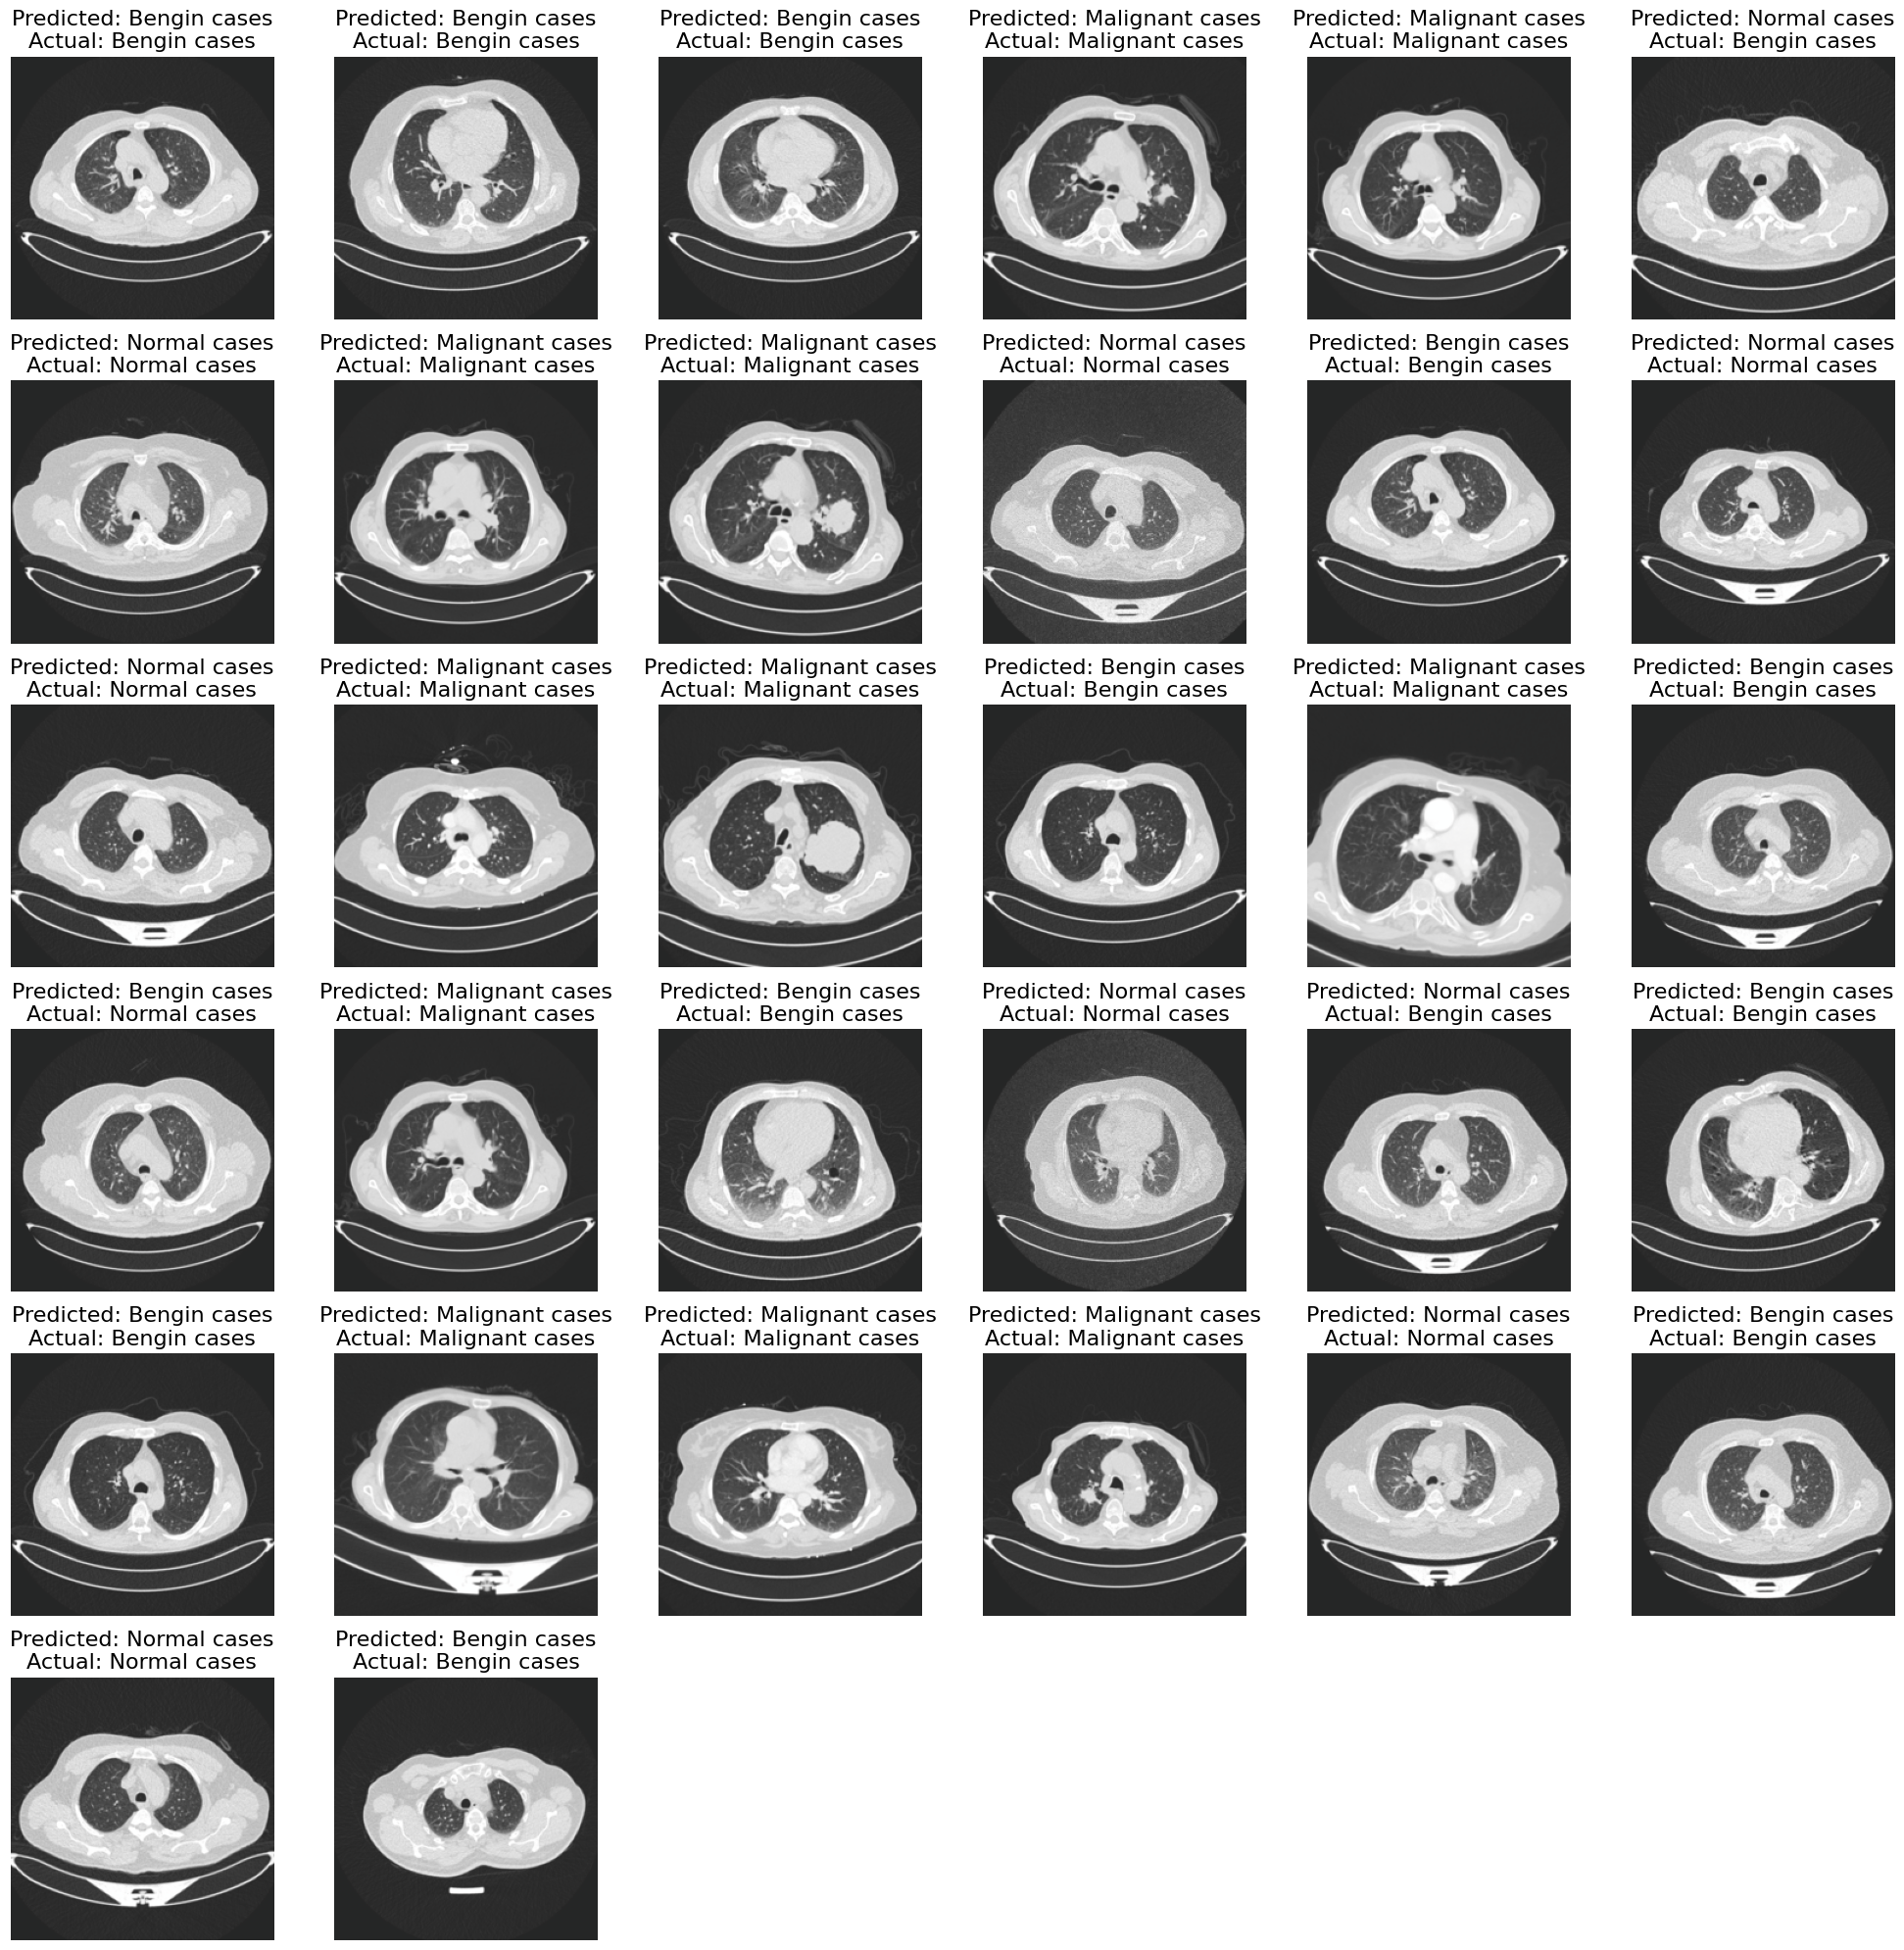

In [14]:
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Convert images to CPU and unnormalize
inputs = inputs.cpu().numpy().transpose(0, 2, 3, 1)
inputs = np.clip(inputs * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

# Plot the images with predictions
plt.figure(figsize=(20, 20))
for i in range(len(inputs)):
    plt.subplot(6, 6, i + 1)
    plt.imshow(inputs[i])
    plt.title(f'Predicted: {reverse_class_dict[preds[i].item()]}\nActual: {reverse_class_dict[labels[i].item()]}', color='black', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()
